Each convolution layer consists of several filters. In practice, they are a number such as 32,64, 128, 256, 512, etc. This is equal to the number of channels in the output of a convolutional layer

In [19]:
import torch
from torch import nn 
import torchvision 
import torchvision.transforms as transforms 
import numpy as np 
import matplotlib.pyplot as plt 
from datetime import datetime


train_dataset = torchvision.datasets.FashionMNIST(root=".", 
                                  train=True, 
                                  transform=transforms.ToTensor(),                          
                                  download=True)
test_dataset = torchvision.datasets.FashionMNIST(root=".", 
                                  train=False, 
                                  transform=transforms.ToTensor(),                          
                                  download=True)


class CNN(nn.Module):

  def __init__(self, K):
    super(CNN, self).__init__()

    self.conv_layers = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=2),
        nn.ReLU(),

        nn.Conv2d(32, 64, kernel_size=3, stride=2),
        nn.ReLU(),

        nn.Conv2d(64, 128, kernel_size=3, stride=2),
        nn.ReLU()

    )

    self.dense_layers = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(128*2*2, 512),

        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, K)
    )
  def forward(self, X):
    out = self.conv_layers(X)
    out = out.view(out.size(0),-1)
    out = self.dense_layers(out)
    return out
K = len(set(train_dataset.targets.numpy()))
model = CNN(K)



batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size = batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = batch_size, 
                                          shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(device)
model.to(device)



def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs) 
  test_losses = np.zeros(epochs)
  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
    
      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())


    train_loss = np.mean(train_loss)

    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
    
      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)  

    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0

    print(f"Epochs {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \ Test Loss: {test_loss:.4f}, Duration: {dt}")
  
  return train_losses, test_losses


#import pdb; 
#pdb.set_trace()
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=15)


Epochs 1/15, Train Loss: 1.0507, \ Test Loss: 0.7336, Duration: 0:00:06.873090
Epochs 2/15, Train Loss: 0.6547, \ Test Loss: 0.6271, Duration: 0:00:06.953082
Epochs 3/15, Train Loss: 0.5734, \ Test Loss: 0.5729, Duration: 0:00:06.800572
Epochs 4/15, Train Loss: 0.5261, \ Test Loss: 0.5343, Duration: 0:00:06.785007
Epochs 5/15, Train Loss: 0.4964, \ Test Loss: 0.5061, Duration: 0:00:06.773493
Epochs 6/15, Train Loss: 0.4719, \ Test Loss: 0.4847, Duration: 0:00:06.834317
Epochs 7/15, Train Loss: 0.4547, \ Test Loss: 0.4703, Duration: 0:00:07.948866
Epochs 8/15, Train Loss: 0.4373, \ Test Loss: 0.4590, Duration: 0:00:07.732604
Epochs 9/15, Train Loss: 0.4244, \ Test Loss: 0.4490, Duration: 0:00:06.747022
Epochs 10/15, Train Loss: 0.4117, \ Test Loss: 0.4370, Duration: 0:00:06.822622
Epochs 11/15, Train Loss: 0.4020, \ Test Loss: 0.4248, Duration: 0:00:06.851150
Epochs 12/15, Train Loss: 0.3907, \ Test Loss: 0.4211, Duration: 0:00:06.800404
Epochs 13/15, Train Loss: 0.3830, \ Test Loss: 0.

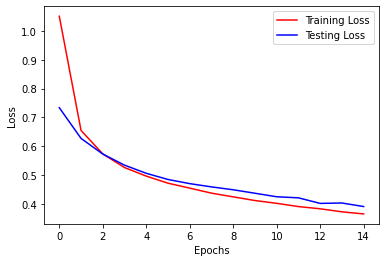

In [20]:
plt.plot(train_losses, "r", label="Training Loss")
plt.plot(test_losses, "b", label="Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
#Train
n_correct = 0
n_total = 0 

for inputs, targets in train_loader:

    inputs, targets = inputs.to(device), targets.to(device)



    outputs = model(inputs)

    _, prediction = torch.max(outputs, 1)

    n_correct += (targets==prediction).sum().item()
    n_total += targets.shape[0]

train_accuracy = n_correct / n_total

#Test

n_correct = 0
n_total = 0 

for inputs, targets in test_loader:

    inputs, targets = inputs.to(device), targets.to(device)



    outputs = model(inputs)

    _, prediction = torch.max(outputs, 1)

    n_correct += (targets==prediction).sum().item()
    n_total += targets.shape[0]

test_accuracy = n_correct / n_total

In [26]:
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.87
Testing Accuracy: 0.86


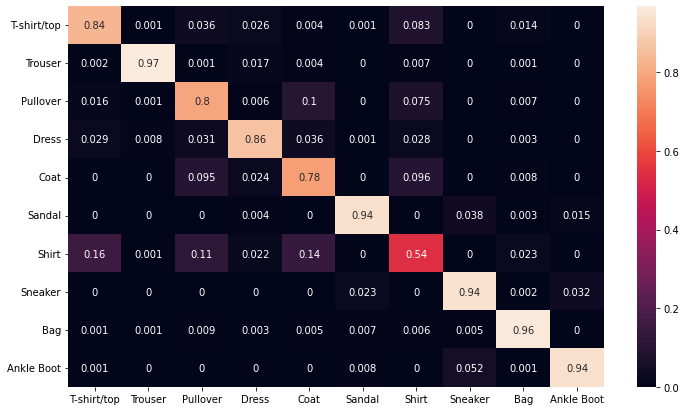

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([]) 

for inputs, targets in test_loader:
    inputs = inputs.to(device)

    #inputs = inputs.view(-1, 784)

    outputs = model(inputs) 

    _, predictions = torch.max(outputs, 1)

    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
       

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix

df_cm = pd.DataFrame(cm/np.sum(cm) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')